In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import xarray as xr
import numpy as np
import fsspec
import intake
from vcm.catalog import catalog 
from vcm.safe import get_variables
from vcm.convenience import round_time
from dask.diagnostics import ProgressBar
import fv3viz
import cftime
import pandas as pd
#import proplot
import matplotlib.pyplot as plt
import os
from datetime import timedelta
import textwrap

import vcm

fsize=14

slmsk = catalog["landseamask/c48"].read()
grid = catalog["grid/c48"].read()

rename_dims = {"grid_xt": "x", "grid_yt": "y", "grid_y": "y_interface", "grid_x": "x_interface"}

def _bias(ds, verif, var, verif_var=None):
    if verif_var is not None:
        verif[var] = verif[verif_var]
    bias = ds[[var]] - verif[[var]]
    return bias

def plot_bias(ds, verif, var, verif_var=None, suptitle=None, kwargs={}):
    fig, subplots, _, cbar, _ = fv3viz.plot_cube(
        _bias(ds, verif, var, verif_var) \
            .merge(grid).mean("time"),
        var,
        col="dataset",
        **kwargs
    )

    for i, name in enumerate(ds.dataset.values):
        lines = "\n".join(
            textwrap.wrap(name, 25, break_long_words=False)
        )
        subplots[0][i].set_title(lines)
    if suptitle:
        fig.suptitle(suptitle, fontsize=18)
    return fig, cbar



def var_rms(bias, area):
    weights = area/area.mean()
    return np.sqrt(((weights*bias)**2).mean(dim=['x', 'y', 'tile']))



def var_mean(bias, area):
    weights = area/area.mean()
    return (weights*bias).mean(dim=['x', 'y', 'tile'])

labels = ["JFM", "AMJ", "JAS", "OND"]

def seasonal_avg(ds):
    seasonal_ = []
    start_year = ds.time.values[0].year
    seasons = [
        slice(cftime.DatetimeJulian(start_year,1,1), cftime.DatetimeJulian(start_year,4,1)),
        slice(cftime.DatetimeJulian(start_year,4,1), cftime.DatetimeJulian(start_year,7,1)),
        slice(cftime.DatetimeJulian(start_year,7,1), cftime.DatetimeJulian(start_year,10,1)),
        slice(cftime.DatetimeJulian(start_year,10,1), cftime.DatetimeJulian(start_year + 1, 1,1)),
    ]    
    for season in seasons:
        seasonal_.append(ds.sel(time=season).mean("time"))
    return xr.concat(seasonal_, dim=pd.Index([str(v) for v in labels], name="season")).load()
    

In [3]:
proplot.rc['grid.alpha'] = 0.6
proplot.rc['grid.linewidth'] = 0.6

In [2]:
from cycler import cycler
import matplotlib as mpl

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

default_colors = ['#006BA4',
 '#FF800E',
 '#ABABAB',
 '#595959',
 '#5F9ED1',
 '#C85200',
 '#898989',
 '#A2C8EC',
 '#FFBC79',
 '#CFCFCF']

colorlist = ['black',  ] + default_colors
linestyle_list = ["--",  ] + ["-" for v in default_colors]


cmap = mpl.colors.ListedColormap(colorlist)
custom_cycler = cycler(color=cmap.colors, linestyle=linestyle_list) #or simply color=colorlist
 

In [3]:
sfc_verif = catalog["2020_1yr_pire_physics"].to_dask().rename({"grid_xt": "x", "grid_yt": "y"})
dyn_verif = catalog["2020_1yr_pire_dyn"].to_dask().rename({"grid_xt": "x", "grid_yt": "y"})

In [4]:
rundirs = [

  {
    "url": "gs://vcm-ml-experiments/n2f-pire-sfc-updates/2022-01-10/baseline-seaice-prescribed/fv3gfs_run",
    "name": "Baseline"
  },
    {
        "url": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-09/decrease-rad-lr-updated-rad-flux-ensemble/fv3gfs_run",
        "name": "NN ensemble"
    },
  {
    "url": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-08/decrease-rad-lr-updated-rad-flux-seed-0/fv3gfs_run",
    "name": "NN seed 0"
  }, 
  {
    "url": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-08/decrease-rad-lr-updated-rad-flux-seed-1/fv3gfs_run",
    "name": "NN seed 1"
  }, 
      {
    "url": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-08/decrease-rad-lr-updated-rad-flux-seed-2/fv3gfs_run",
    "name": "NN seed 2"
  }, 
      {
    "url": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-08/decrease-rad-lr-updated-rad-flux-seed-3/fv3gfs_run",
    "name": "NN seed 3"
  }, 
]


In [5]:


runs  = {
    run["name"]:
        intake.open_zarr(os.path.join(run["url"], "diags.zarr"))
        .to_dask()
        .resample(time='1D').mean()
    for run in rundirs
}
 

In [6]:
runs_sfc = {
    run["name"]:
        intake.open_zarr(os.path.join(run["url"], "state_after_timestep.zarr"))
        .to_dask()
        [["latent_heat_flux", "sensible_heat_flux", "surface_temperature"]]
        .resample(time='1D').mean()
    for run in rundirs
}

In [7]:
all_times = [data.time.values for data in runs.values()]
sfc_verif = sfc_verif.resample(time='1D').mean()

common_times = sorted(
    list(
        set.intersection(*map(set, all_times)) \
            .intersection(sfc_verif.time.values)
    )
)
merged = xr.concat(
    [run[["total_precipitation_rate", "water_vapor_path"]] #.sel(time=common_times) 
     for run in runs.values()],
    dim=pd.Index([name for name in runs], name="dataset"),
)
merged_sfc = xr.concat(
    [run     for run in runs_sfc.values()],
    dim=pd.Index([name for name in runs], name="dataset"),
)

In [8]:
kg_m2s_to_mm_day = (1e3 * 86400) / 997.0
merged['land_precip_mm_d'] = (merged["total_precipitation_rate"] * kg_m2s_to_mm_day).where(slmsk["land_sea_mask"] == 1.)
sfc_verif['land_precip_mm_d'] = (sfc_verif["PRATEsfc_coarse"] * kg_m2s_to_mm_day)  .where(slmsk["land_sea_mask"] == 1.)


merged['precip_mm_d'] = (merged["total_precipitation_rate"] * kg_m2s_to_mm_day)
sfc_verif['precip_mm_d'] = (sfc_verif["PRATEsfc_coarse"] * kg_m2s_to_mm_day)  


#### Time mean global/ land / sea breakdown of RMSE

In [10]:
masks = {"global": slmsk["land_sea_mask"]>=0, "land": slmsk["land_sea_mask"]==1., "ocean":  slmsk["land_sea_mask"]==0.}
precip_bias, precip_rmse = {}, {}

precip_time_mean_bias_ = ((merged["total_precipitation_rate"] * kg_m2s_to_mm_day) - (sfc_verif["PRATEsfc_coarse"] * kg_m2s_to_mm_day)).mean("time").load()

for sfc_type, mask_cond in masks.items():
    precip_rmse[sfc_type] = var_rms(
        precip_time_mean_bias_.where(mask_cond),
        grid.area.where(mask_cond)
    )
    precip_bias[sfc_type] = var_mean(
        precip_time_mean_bias_.where(mask_cond),
        grid.area.where(mask_cond)
    )


In [35]:
precip_rmse

{'global': <xarray.DataArray (dataset: 6)>
 array([1.91027261, 1.60324555, 1.50812706, 1.65087916, 1.67012298,
        1.64647851])
 Coordinates:
   * dataset  (dataset) object 'Baseline' 'NN ensemble' ... 'NN seed 3',
 'land': <xarray.DataArray (dataset: 6)>
 array([1.70713301, 1.41200979, 1.28548365, 1.42445597, 1.55239486,
        1.51899217])
 Coordinates:
   * dataset  (dataset) object 'Baseline' 'NN ensemble' ... 'NN seed 3',
 'ocean': <xarray.DataArray (dataset: 6)>
 array([2.05482557, 1.72934031, 1.64005273, 1.7933439 , 1.77306457,
        1.75294366])
 Coordinates:
   * dataset  (dataset) object 'Baseline' 'NN ensemble' ... 'NN seed 3'}

In [36]:
for domain in [ "global",  "land", "ocean" ]:
    baseline_precip_rmse = precip_rmse[domain].sel(dataset="Baseline").values
    ml_precip_rmse = precip_rmse[domain].sel(dataset=[f"NN seed {i}" for i in range(4)]).values
    percent_precip_improvements = (baseline_precip_rmse - ml_precip_rmse)/baseline_precip_rmse
    min = f'{100 * percent_precip_improvements.min():.{0}f}'
    max = f'{100 * percent_precip_improvements.max():.{0}f}'

    print(f"Precip RMSE improvement, {domain}: {min} - {max} %")

Precip RMSE improvement, global: 13 - 21 %
Precip RMSE improvement, land: 9 - 25 %
Precip RMSE improvement, ocean: 13 - 20 %


In [37]:
masks = {"global":  grid.area, "land":  grid.area.where(slmsk["land_sea_mask"]==1.), "ocean":  grid.area.where(slmsk["land_sea_mask"]==0.)}
tsfc_bias, tsfc_rmse = {}, {}

tsfc_time_mean_bias_ = (merged_sfc["surface_temperature"] - sfc_verif["tsfc_coarse"]) .mean("time").load()

for sfc_type, mask in masks.items():
    tsfc_rmse[sfc_type] = var_rms(
        tsfc_time_mean_bias_,
        mask
    )
    tsfc_bias[sfc_type] = var_mean(
        tsfc_time_mean_bias_,
        mask
    )
    

In [38]:
tsfc_rmse

{'global': <xarray.DataArray (dataset: 6)>
 array([2.66434876, 2.09222435, 1.98627526, 2.20393634, 2.57568861,
        2.1682571 ])
 Coordinates:
   * dataset  (dataset) object 'Baseline' 'NN ensemble' ... 'NN seed 3',
 'land': <xarray.DataArray (dataset: 6)>
 array([4.87208368, 3.75442487, 3.62286217, 4.02731993, 4.59351117,
        3.9033744 ])
 Coordinates:
   * dataset  (dataset) object 'Baseline' 'NN ensemble' ... 'NN seed 3',
 'ocean': <xarray.DataArray (dataset: 6)>
 array([0.35650292, 0.2843697 , 0.19534593, 0.34771587, 0.37097221,
        0.30371274])
 Coordinates:
   * dataset  (dataset) object 'Baseline' 'NN ensemble' ... 'NN seed 3'}

In [39]:
for domain in [  "land" ]:
    baseline_tsfc_rmse = tsfc_rmse[domain].sel(dataset="Baseline").values
    ml_tsfc_rmse = tsfc_rmse[domain].sel(dataset=[f"NN seed {i}" for i in range(4)]).values
    percent_tsfc_improvements = (baseline_tsfc_rmse - ml_tsfc_rmse)/baseline_tsfc_rmse
    min = f'{100 * percent_tsfc_improvements.min():.{0}f}'
    max = f'{100 * percent_tsfc_improvements.max():.{0}f}'

    print(f"Tsfc RMSE improvement, {domain}: {min} - {max} %")

Tsfc RMSE improvement, land: 6 - 26 %


#### Land precip  RMSE over time

In [40]:
precip_seasonal_bias =  seasonal_avg(merged["land_precip_mm_d"] - sfc_verif["land_precip_mm_d"]).load()
precip_seasonal_rms_land = var_rms(precip_seasonal_bias, grid.area.where(slmsk["land_sea_mask"]==1.))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

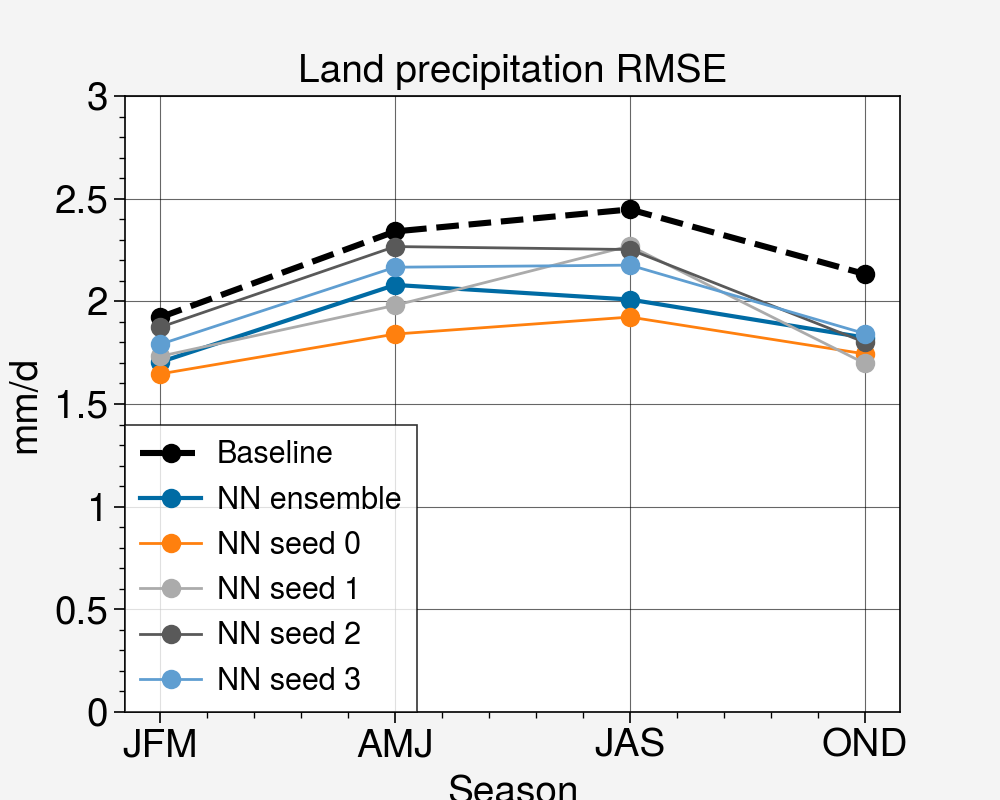

In [74]:
import proplot

proplot.rc['grid.alpha'] = 0.6
proplot.rc['grid.linewidth'] = 0.4

fig = plt.figure(figsize=(5,4))
ax = plt.gca()

ax.set_prop_cycle(custom_cycler)
precip_seasonal_rms_land = precip_seasonal_rms_land.assign_coords({"season": [str(v) for v in precip_seasonal_rms_land.season.values]})

plt.plot(
    precip_seasonal_rms_land.season.values,
    precip_seasonal_rms_land.sel(dataset="Baseline").values,
    linewidth=2.2,
    marker='o',
    label="Baseline"
)
plt.plot(
    precip_seasonal_rms_land.season.values,
    precip_seasonal_rms_land.sel(dataset="NN ensemble").values,
    label="NN ensemble",
    marker='o'
)

for i in range(4):
    plt.plot(
        precip_seasonal_rms_land.season.values,
        precip_seasonal_rms_land.sel(dataset=f"NN seed {i}").values,
        label=f"NN seed {i}",
        linewidth=1, 
        marker='o'
    )



plt.xlabel("Season", fontsize=fsize)
plt.ylabel("mm/d", fontsize=fsize)
plt.title("Land precipitation RMSE", fontsize=fsize)
plt.legend(loc = "lower left", fontsize=11)
plt.tick_params(axis='both', labelsize=fsize)
plt.ylim(0, 3)

plt.savefig("figures/pdf/prognostic_seasonal_land_precip_rmse.pdf", dpi=200, bbox_inches="tight")
plt.savefig("figures/png/prognostic_seasonal_land_precip_rmse.png", dpi=200, bbox_inches="tight")
plt.savefig("figures/eps/prognostic_seasonal_land_precip_rmse.eps", format="eps", bbox_inches="tight")

#### TMPsfc RMSE over time

In [43]:
tsfc_seasonal_bias =  seasonal_avg(merged_sfc["surface_temperature"] - sfc_verif["tsfc_coarse"]).load()
tsfc_seasonal_rms_land = var_rms(tsfc_seasonal_bias.where(slmsk["land_sea_mask"]==1.), grid.area.where(slmsk["land_sea_mask"]==1.))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

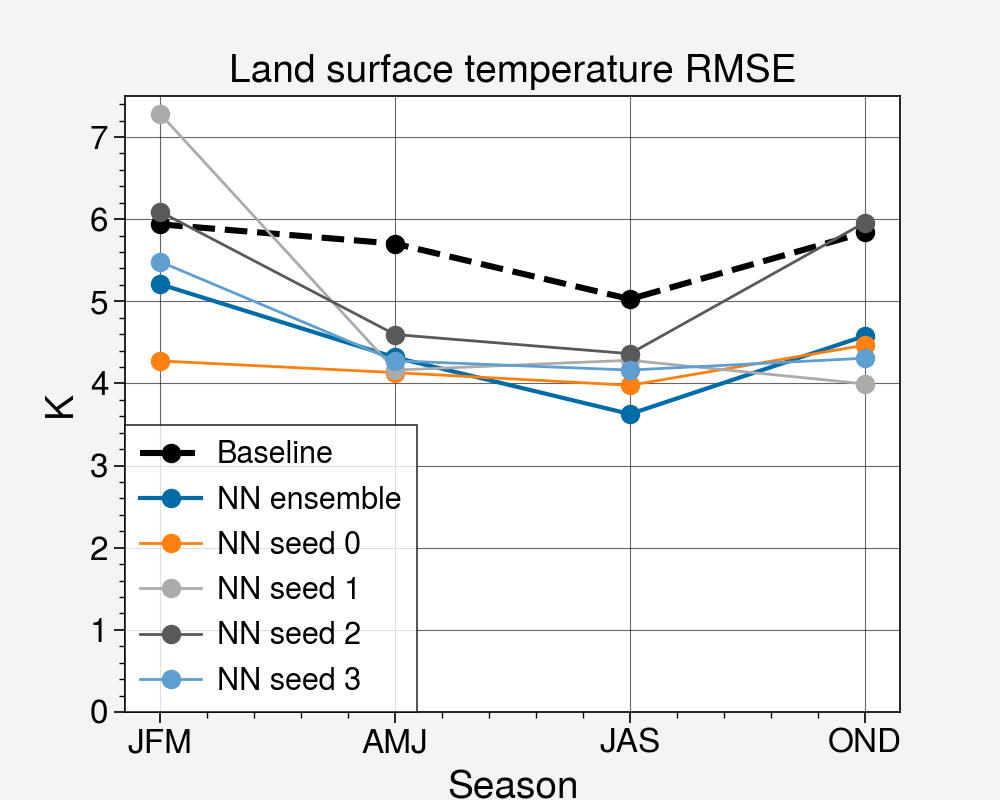

In [75]:
fig = plt.figure(figsize=(5,4))

ax = plt.gca()

ax.set_prop_cycle(custom_cycler)
tsfc_seasonal_rms_land = tsfc_seasonal_rms_land.assign_coords({"season": [str(v) for v in tsfc_seasonal_rms_land.season.values]})



plt.plot(
    tsfc_seasonal_rms_land.season.values,
    tsfc_seasonal_rms_land.sel(dataset="Baseline").values,
    linewidth=2.2,
    marker='o',
    label="Baseline"
)
plt.plot(
    tsfc_seasonal_rms_land.season.values,
    tsfc_seasonal_rms_land.sel(dataset="NN ensemble").values,
    label="NN ensemble",
    marker='o'
)

for i in range(4):
    plt.plot(
        tsfc_seasonal_rms_land.season.values,
        tsfc_seasonal_rms_land.sel(dataset=f"NN seed {i}").values,
        label=f"NN seed {i}",
        linewidth=1, 
        marker='o'
    )

plt.xlabel("Season", fontsize=fsize)
plt.ylabel("K", fontsize=fsize)
plt.title("Land surface temperature RMSE", fontsize=fsize)
plt.legend(loc = "lower left", fontsize=11)
plt.tick_params(axis='both', labelsize=12)

plt.ylim(0, 7.5)

plt.savefig("figures/pdf/prognostic_seasonal_land_tsfc_rmse.pdf", dpi=200)
plt.savefig("figures/png/prognostic_seasonal_land_tsfc_rmse.png", dpi=200)
plt.savefig("figures/eps/prognostic_seasonal_land_tsfc_rmse.eps", format="eps", bbox_inches="tight")



#### Time average maps: surface temperature

<Figure size 864x576 with 0 Axes>

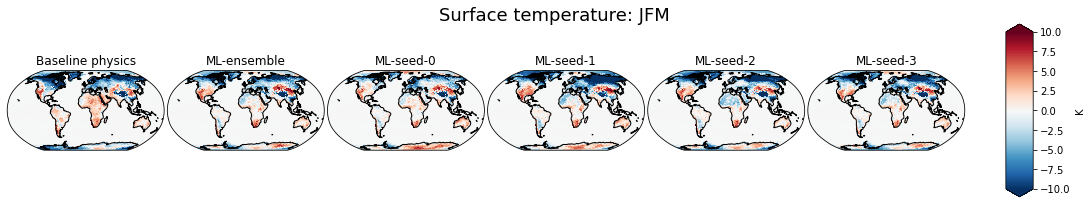

<Figure size 864x576 with 0 Axes>

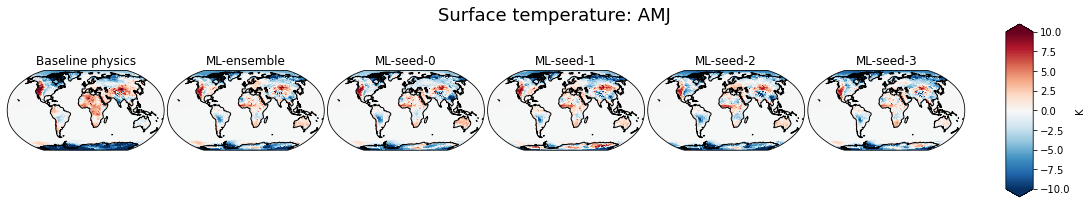

<Figure size 864x576 with 0 Axes>

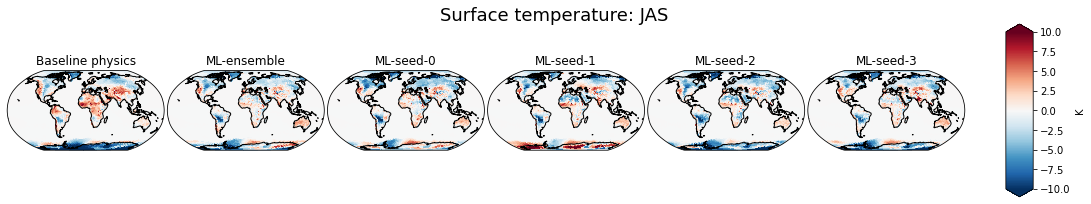

<Figure size 864x576 with 0 Axes>

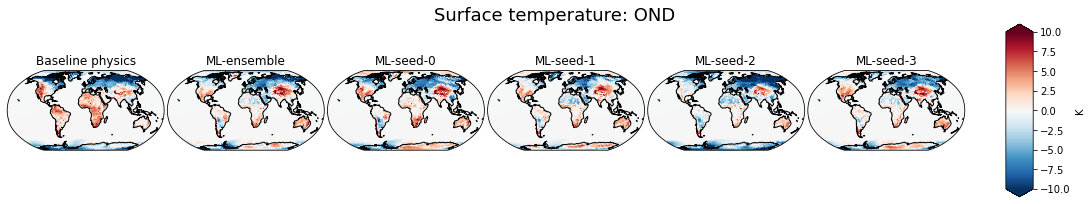

In [21]:


for season in tsfc_seasonal_bias.season.values:
    fig=plt.figure(figsize=(12,8))
    ds_ = xr.merge([tsfc_seasonal_bias.sel(season=season).rename("surface_temperature"), grid])
    fig, subplots, _, _, _  = fv3viz.plot_cube(ds_, "surface_temperature", col="dataset", vmax=10, cbar_label="K")
    for i, name in enumerate(ds_.dataset.values):
        lines = "\n".join(
            textwrap.wrap(name, 25, break_long_words=False)
        )
        subplots[0][i].set_title(lines)
    fig.suptitle(f"Surface temperature: {str(season)}", fontsize=18)
    plt.show()


Text(0.5, 0.98, 'Surface temperature bias [K]')

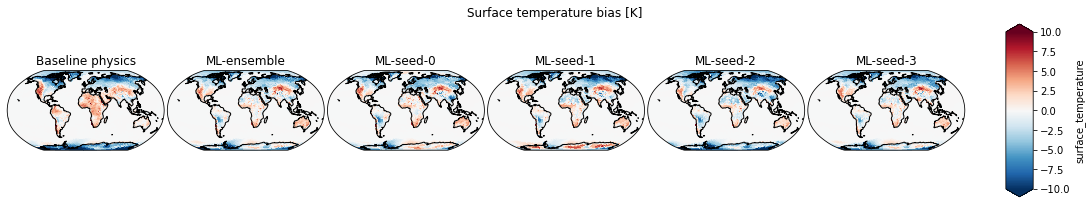

In [27]:
fig = plot_bias(
    merged_sfc,
    sfc_verif, 
    var="surface_temperature", 
    verif_var="tsfc_coarse",
    kwargs={"vmax": 10},
) 
plt.suptitle("Surface temperature bias [K]")
#plt.savefig("figures/pdf/prognostic_year_avg_land_tsfc_bias_map.pdf", dpi=200)

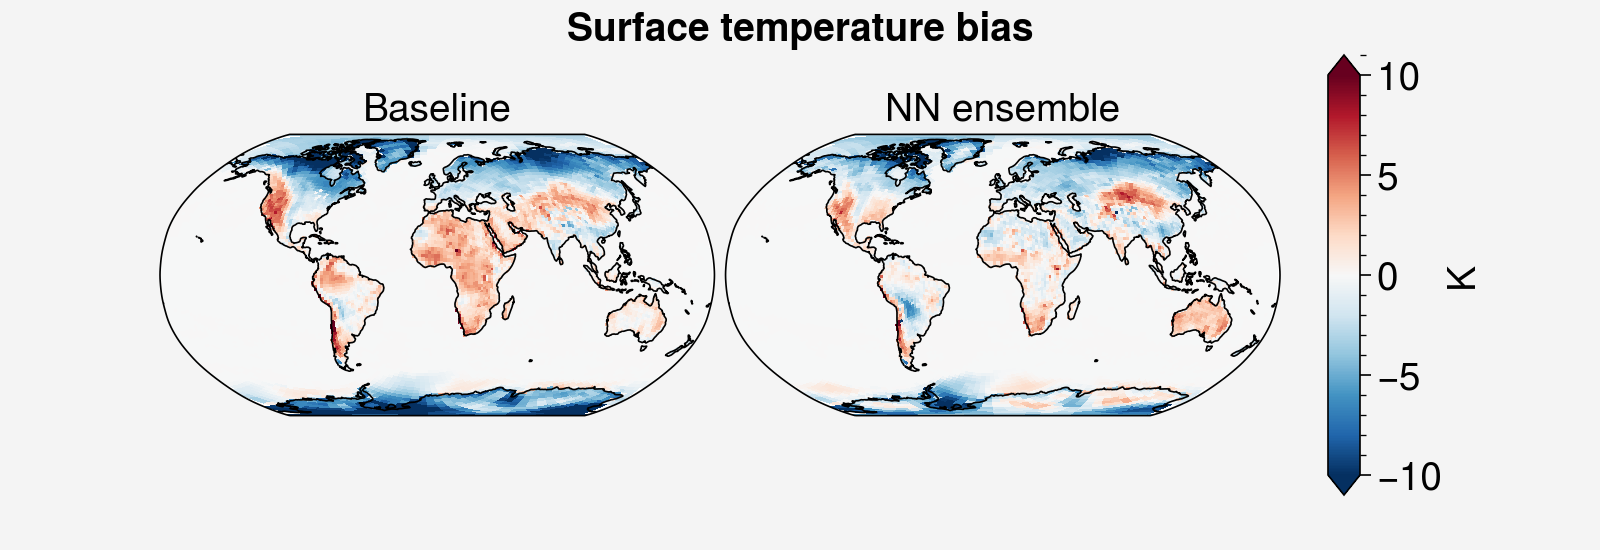

In [49]:
fig, cbar = plot_bias(
    merged_sfc.sel(dataset=['Baseline', 'NN ensemble']),
    sfc_verif, 
    var="surface_temperature", 
    verif_var="tsfc_coarse",
    kwargs={"vmax": 10},
) 
plt.suptitle("Surface temperature bias", fontsize=fsize)
fig.axes[0].set_title('Baseline', fontsize=fsize)
fig.axes[1].set_title('NN ensemble', fontsize=fsize)
cbar.set_label("K", fontsize=fsize, labelpad=1)
cbar.ax.tick_params(labelsize=fsize) 

fig.set_size_inches(8, 2.75)

plt.savefig("figures/pdf/prognostic_year_avg_land_tsfc_bias_map.pdf", dpi=200, bbox_inches="tight")
plt.savefig("figures/png/prognostic_year_avg_land_tsfc_bias_map.png", dpi=200, bbox_inches="tight")
plt.savefig("figures/eps/prognostic_year_avg_land_tsfc_bias_map.eps", format="eps", bbox_inches="tight")


#### Time average maps: surface precipitation

<Figure size 864x576 with 0 Axes>

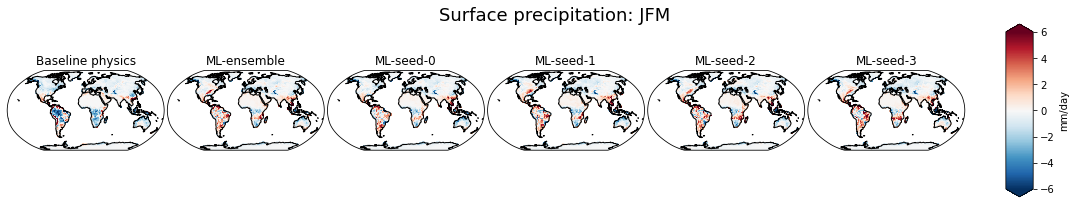

<Figure size 864x576 with 0 Axes>

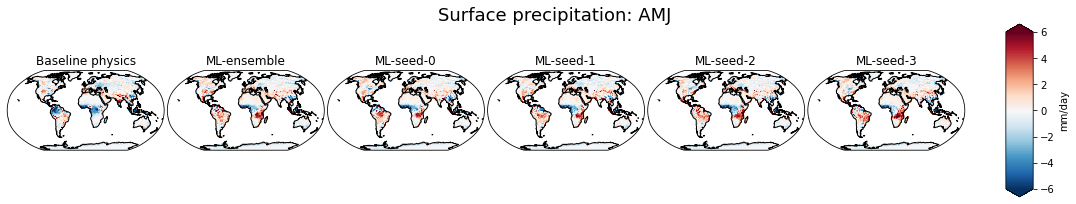

<Figure size 864x576 with 0 Axes>

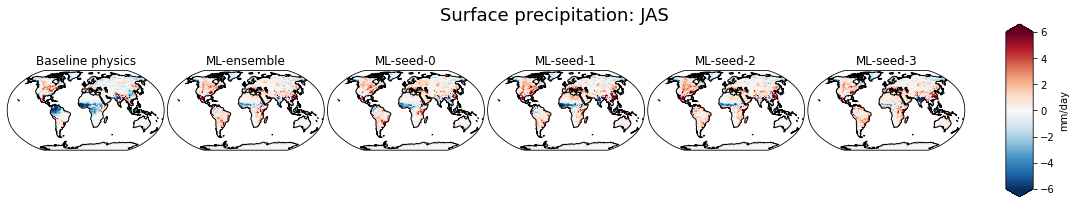

<Figure size 864x576 with 0 Axes>

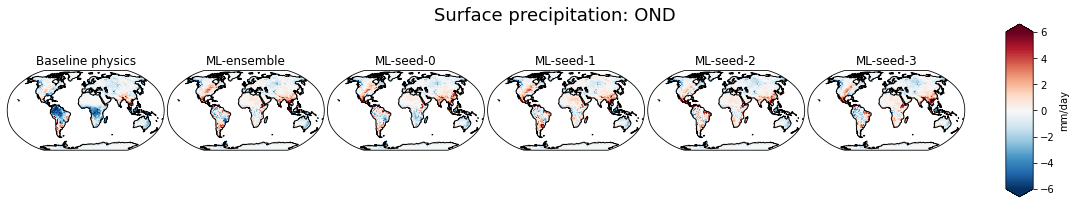

In [23]:


for season in precip_seasonal_bias.season.values:
    fig=plt.figure(figsize=(12,8))
    ds_ = xr.merge([precip_seasonal_bias.sel(season=season).rename("surface_precip"), grid])
    fig, subplots, _, _, _  = fv3viz.plot_cube(ds_, "surface_precip", col="dataset", vmax=6, cbar_label="mm/day")
    for i, name in enumerate(ds_.dataset.values):
        lines = "\n".join(
            textwrap.wrap(name, 25, break_long_words=False)
        )
        subplots[0][i].set_title(lines)
    fig.suptitle(f"Surface precipitation: {str(season)}", fontsize=18)
    plt.show()


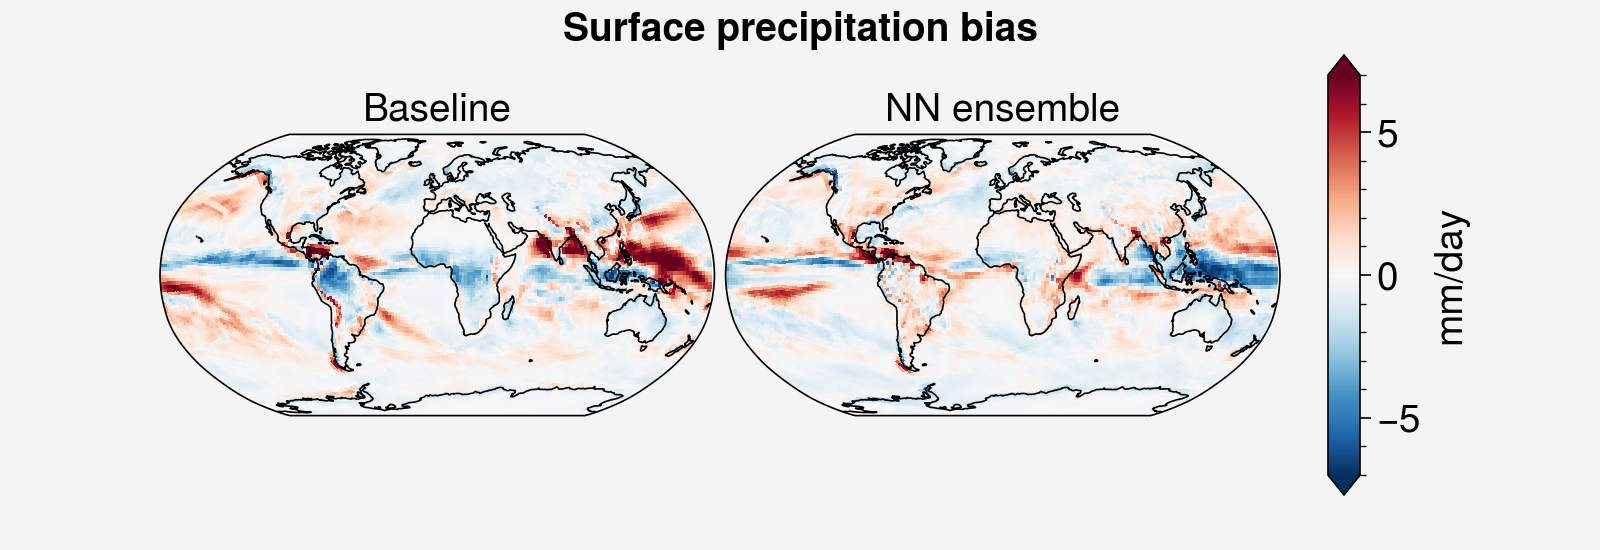

In [48]:
fig, cbar = plot_bias(
    merged.sel(dataset=['Baseline', 'NN ensemble']),
    sfc_verif, 
    var="precip_mm_d", 
    verif_var="precip_mm_d",
    kwargs={"vmax": 7},
    
) 
plt.suptitle("Surface precipitation bias", fontsize=fsize)
fig.axes[0].set_title("Baseline", fontsize=fsize)
fig.axes[1].set_title('NN ensemble', fontsize=fsize)
cbar.set_label('mm/day', fontsize=fsize)
cbar.ax.tick_params(labelsize=fsize) 

fig.set_size_inches(8, 2.75)

plt.savefig("figures/pdf/prognostic_year_avg_precip_bias_map.pdf", dpi=200, bbox_inches="tight")
plt.savefig("figures/png/prognostic_year_avg_precip_bias_map.png", dpi=200, bbox_inches="tight")
plt.savefig("figures/eps/prognostic_year_avg_precip_bias_map.eps", format="eps", bbox_inches="tight")


Text(0.5, 0.98, 'Surface precipitation bias [mm/day]')

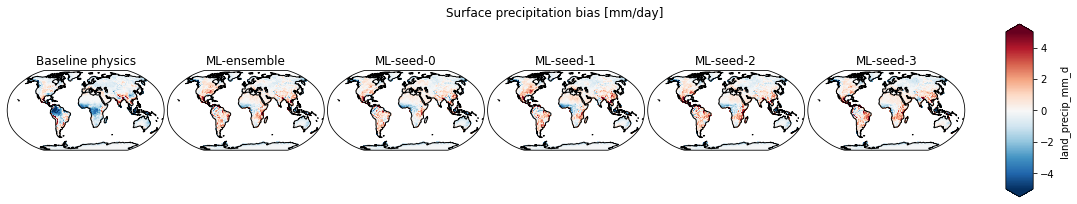

In [28]:
fig = plot_bias(
    merged,
    sfc_verif, 
    var="land_precip_mm_d", 
    verif_var="land_precip_mm_d",
    kwargs={"vmax": 5},
) 
plt.suptitle("Surface precipitation bias [mm/day]")
#plt.savefig("figures/pdf/prognostic_year_avg_land_precip_bias_map.pdf", dpi=200)

#### Bar plots for precip metrics over domains

In [11]:
precip_metrics = []

for mask, da in precip_rmse.items():
    #da["dataset"] = ["Baseline", "NN ensemble"] +[f"NN seed {i}" for i in range(4)]
    for run, rmse in zip(da.dataset.values, da.values):
        precip_bias_masked = precip_bias[mask]
        #precip_bias_masked["dataset"] = ["Baseline", "NN ensemble"] +[f"NN seed {i}" for i in range(4)]
        bias = precip_bias_masked.sel(dataset=run).values.item()
        precip_metrics.append([mask, run, rmse, bias])
        
df = pd.DataFrame(precip_metrics, columns=["domain", "run", "RMSE", "bias"])


In [12]:
df

,domain,run,RMSE,bias
0,global,Baseline,1.910273,0.132751
1,global,NN ensemble,1.603246,-0.014989
2,global,NN seed 0,1.508127,-0.048730
3,global,NN seed 1,1.650879,0.034811
4,global,NN seed 2,1.670123,0.043277
5,global,NN seed 3,1.646479,0.032622
6,land,Baseline,1.707133,-0.453658
7,land,NN ensemble,1.412010,0.165760
8,land,NN seed 0,1.285484,0.053195
9,land,NN seed 1,1.424456,0.162147


In [13]:
import seaborn as sb
sb.reset_orig()
    

import fv3viz
fv3viz.use_colorblind_friendly_style()



In [222]:
col = "RMSE"

for domain in ["global", "land", "ocean"]:
    ML_results = df[df['domain']==domain][1:][col] .values
    baseline_result =  df[df['domain']==domain][df['run']=='Baseline'][col] .values

    percent_improvement = (baseline_result - ML_results  ) /baseline_result

    min = f'{100 * percent_improvement.min():.{0}f}'
    max = f'{100 * percent_improvement.max():.{0}f}'

    print(f"{domain} ML improvements over baseline {col}: {min} - {max}%")

global ML improvements over baseline RMSE: 13 - 21%
land ML improvements over baseline RMSE: 9 - 25%
ocean ML improvements over baseline RMSE: 13 - 20%


In [223]:
col = "bias"

for domain in ["global", "land", "ocean"]:
    ML_results = df[df['domain']==domain][1:][col] .values
    baseline_result =  df[df['domain']==domain][df['run']=='Baseline'][col] .values
    percent_improvement = (abs(baseline_result) - abs(ML_results) ) / abs(baseline_result)

    min = f'{100 * percent_improvement.min():.{0}f}'
    max = f'{100 * percent_improvement.max():.{0}f}'

    print(f"{domain} ML improvements over baseline {col}: {min} - {max}%")

global ML improvements over baseline bias: 63 - 89%
land ML improvements over baseline bias: 43 - 88%
ocean ML improvements over baseline bias: 82 - 98%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


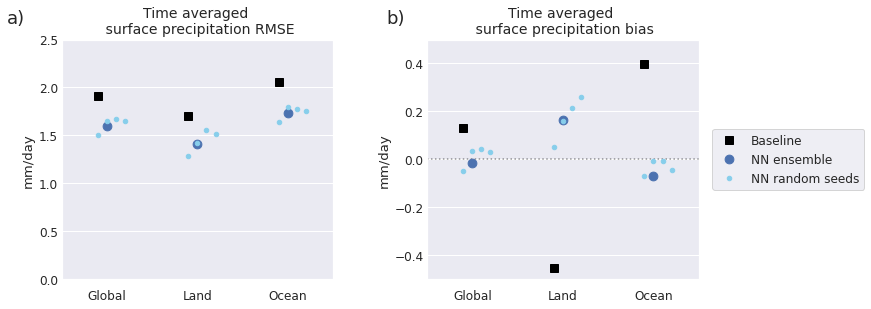

In [252]:
baseline =  df[df["run"]=="Baseline"]
ensemble = df[df["run"]=="NN ensemble"]
seeds =  df[df["run"].isin([f"NN seed {i}" for i in range(4)])]


fig = plt.figure(figsize=(12., 4.5))

sb.set(font_scale = 1.1)

x_start, delta_x = 0.9, 1.0
dot_spacing=0.1

# left plot: RMSE
 
ax0 = fig.add_subplot(121)
ax0.set_xlim(0.5, 3.5)
ax0.set_xticks([1, 2, 3])
ax0.set_xticklabels(['Global', 'Land', 'Ocean'] )

for i, domain in enumerate(["global", "land", "ocean"]):

    ax0.plot(
        [x_start + delta_x * i], 
        baseline[baseline["domain"]==domain]["RMSE"].values, 
        's',
        markersize=8.75,
        color='black',
        label="Baseline" if i==0 else None
    )
    ax0.plot(
        [x_start + delta_x * i +  dot_spacing], 
        ensemble[ensemble["domain"]==domain]["RMSE"].values, 
        'o',
        color=default_colors[0],
        markersize=8.75,
        label="NN ensemble" if i==0 else None
    )
     
    ax0.plot(
        [x_start + delta_x * i + dot_spacing * j for j in range(4)], 
        seeds[seeds["domain"]==domain]["RMSE"].values, 
        'o',
        markersize=4.5,
        color='skyblue',
        label="NN random seeds" if i==0 else None
    )
ax0.tick_params(axis="y", width=0.0, length=0,)# direction="in")
ax0.set_ylim(0., 2.5)
ax0.xaxis.grid(False)
ax0.text(-0.2, 1.125, "a)", va='top', fontsize=18, transform=ax0.transAxes)

ax0.set_ylabel('mm/day')
ax0.set_title(f"Time averaged \n surface precipitation RMSE", fontsize=14)

    
# right plot: bias

ax1 = fig.add_subplot(122)
ax1.set_xlim(0.5, 3.5)
ax1.set_xticks([1, 2, 3])
ax1.set_xticklabels(['Global', 'Land', 'Ocean'] )
ax1.plot(plt.xlim(), [0., 0.], ":", color='black', alpha=0.4)

for i, domain in enumerate(["global", "land", "ocean"]):

    ax1.plot(
        [x_start + delta_x * i], 
        baseline[baseline["domain"]==domain]["bias"].values, 
        's',
        markersize=8.75,
        color='black',
        label="Baseline" if i==0 else None
    )
    ax1.plot(
        [x_start + delta_x * i +  dot_spacing], 
        ensemble[ensemble["domain"]==domain]["bias"].values, 
        'o',
        color=default_colors[0],
        markersize=8.75,
        label="NN ensemble" if i==0 else None
    )
     
    ax1.plot(
        [x_start + delta_x * i + dot_spacing * j for j in range(4)], 
        seeds[seeds["domain"]==domain]["bias"].values, 
        'o',
        markersize=4.5,
        color='skyblue',
        label="NN random seeds" if i==0 else None
    )
ax1.tick_params(axis="y", width=0.0, length=0,)# direction="in")
ax1.set_ylim(-0.5, 0.5)
ax1.xaxis.grid(False)
ax1.text(-0.15, 1.125, "b)", va='top', fontsize=18, transform=ax1.transAxes)


ax1.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)
ax1.set_ylabel('mm/day')
ax1.set_title(f"Time averaged \n surface precipitation bias", fontsize=14)

plt.subplots_adjust(wspace=3.)
plt.tight_layout()


plt.savefig('figures/png/prognostic_precip_time_mean_metrics.png', dpi=150, bbox_inches="tight")
plt.savefig('figures/pdf/prognostic_precip_time_mean_metrics.pdf', dpi=150, bbox_inches="tight")
plt.savefig('figures/eps/prognostic_precip_time_mean_metrics.eps', format="eps", bbox_inches="tight")